In [1]:
# Install notebook dependencies
import sys

#!{sys.executable} -m pip install --pre --upgrade itk


In [2]:
# Import notebook dependencies
import os
import requests
import shutil

import itk
import matplotlib.pyplot as plt
import numpy as np

# Verify we have an up-to-date version of ITK (5.3RC4+)
print(f"Using ITK installation from {itk.__file__}")
assert "SpatialOrientationEnums" in dir(itk)


Using ITK installation from C:\Dev\ITK-py\Wrapping\Generators\Python\itk\__init__.py


In [3]:
# Retrieve hosted sample data from data.kitware.com
files_and_hashes = (
    (
        "data/DzZ_T1.mha",
        "039183ec990bb687e9e8f44ea3b1aebd8cd3444962d69e4e21c44975fb6e57801de12582cc723a8482108b6efd2214de3e9cb0d412bae0c80eafdcde95ae2bf4",
    ),
    (
        "data/brainweb165a10f17Rot10Tx15.mha",
        "61dc94a5213fce670178b38d92b70e45390db3838014a8e2aa5b3dab8c91aee45bffb5c291bb54a2a0eb292ae0754a2e9aa15fdd17c58fd28860e6e51504f17b",
    ),
    (
        "data/C0004255.mha",
        "fbc4c22e174df8039783728b7c84f6239c7bba0425b9c3f4c594aaefa0087423202d0616017a1314e4455b4c433077f40cfd1cd0f024aae5310eba45f8554718",
    ),
)

os.makedirs("data", exist_ok=True)

for idx in range(len(files_and_hashes)):
    if os.path.exists(files_and_hashes[idx][0]):
        print(f"{files_and_hashes[idx][0]} already exists.")
    else:
        download_url = f"https://data.kitware.com/api/v1/file/hashsum/sha512/{files_and_hashes[idx][1]}/download"
        print(f"Downloading {download_url} into {files_and_hashes[idx][0]}")
        response = requests.get(download_url, stream=True)
        with open(files_and_hashes[idx][0], "wb") as fp:
            response.raw.decode_content = True
            shutil.copyfileobj(response.raw, fp)


data/DzZ_T1.mha already exists.
data/brainweb165a10f17Rot10Tx15.mha already exists.
data/C0004255.mha already exists.


Direction of original image:
itkMatrixD33 ([[0.0001779299369092507, 0.0025409210012914763, -0.9999967560295555], [0.9902406488785104, -0.1393680549202613, -0.00017792995659020848], [-0.13936795058263612, -0.9902373902192385, -0.002540919380088758]])


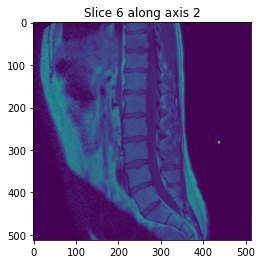

Orient filter will rearrange pixels in memory.

Direction of oriented image:
itkMatrixD33 ([[0.9999967560295555, 0.0001779299369092507, -0.0025409210012914763], [0.00017792995659020848, 0.9902406488785104, 0.1393680549202613], [0.002540919380088758, -0.13936795058263612, 0.9902373902192385]])


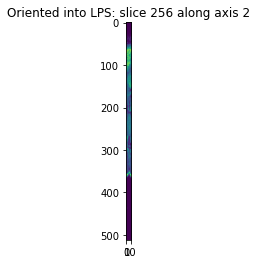

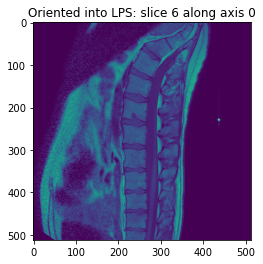

In [4]:
image = itk.imread(files_and_hashes[0][0])
print(f"Direction of original image:\n{image.GetDirection()}")

direction = image.GetDirection()
size = image.GetLargestPossibleRegion().GetSize()
mid_slice = int(size[2] / 2)
plt.imshow(image[mid_slice, :, :], aspect="equal")
plt.title(f"Slice {mid_slice} along axis 2")
plt.show()

itk_so_enums = itk.SpatialOrientationEnums  # shortens next line
dicom_lps = itk_so_enums.ValidCoordinateOrientations_ITK_COORDINATE_ORIENTATION_RAI

orient_filter = itk.OrientImageFilter.New(
    image,
    use_image_direction=True,
    desired_coordinate_orientation=dicom_lps,
)
orient_filter.UpdateOutputInformation()

if np.any(orient_filter.GetOutput().GetDirection() != direction):
    print("Orient filter will rearrange pixels in memory.\n")
    orient_filter.Update()
    image2 = orient_filter.GetOutput()
    size2 = image2.GetLargestPossibleRegion().GetSize()
    print(f"Direction of oriented image:\n{image2.GetDirection()}")

    mid_slice2 = int(size2[2] / 2)
    plt.imshow(image2[mid_slice2, :, :], aspect="equal")
    plt.title(f"Oriented into LPS: slice {mid_slice2} along axis 2")
    plt.show()

    mid_slice0 = int(size2[0] / 2)
    plt.imshow(image2[:, :, mid_slice0], aspect="equal")
    plt.title(f"Oriented into LPS: slice {mid_slice0} along axis 0")
    plt.show()
else:
    print("Orienting will be a no-op.")
    # Allows us to skip some processing


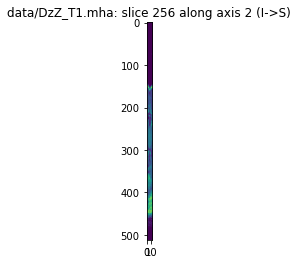

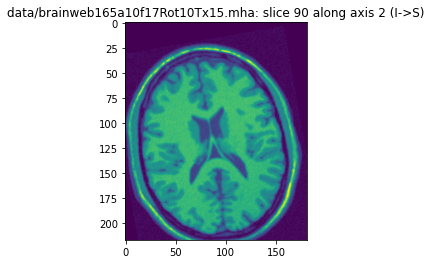

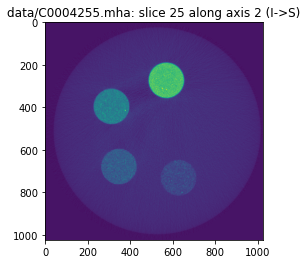

In [5]:
# reorient all images into consistent orientation

itk_so_enums = itk.SpatialOrientationEnums  # shortens next line
dicom_ras = itk_so_enums.ValidCoordinateOrientations_ITK_COORDINATE_ORIENTATION_LPI

for i in range(len(files_and_hashes)):
    image_i = itk.imread(files_and_hashes[i][0])

    # This invokes the filter immediately using procedural interface
    oriented = itk.orient_image_filter(
        image_i,
        use_image_direction=True,
        desired_coordinate_orientation=dicom_ras,
    )

    size_i = oriented.GetLargestPossibleRegion().GetSize()
    z_slice_i = int(size_i[2] / 2)
    plt.imshow(oriented[z_slice_i, :, :], aspect="equal")
    plt.title(f"{files_and_hashes[i][0]}: slice {z_slice_i} along axis 2 (I->S)")
    plt.show()
